Hoy profundisaremos el tema de los numpy array y veremos un poco mas como se puede utilizar las regresiones.

In [1]:
#import netcdf library
from netCDF4 import Dataset as nc 
#import date conversor netcdf
from netCDF4 import num2date, date2num 
from datetime import date, timedelta, datetime
import numpy as np
import os
from scipy import stats
import sys

In [2]:
#definimos una funcion que coge en argumento un fichiero unas latitude y longitude 
#y devuelve los datos correspondientes
def readregion(file, varname, lon_bnds, lat_bnds):
    """funcion que lee los datos 3D en una region
    filename: path de un fichiero netcdf
    varname: nombre de la variable
    lon_bnds: array, list o tuple que contiene los limites de la caja a selecionar
    lat_bnds: array, list o tuple que contiene los limites de la caja a selecionar
    return: var, time, lon, lat
    """
    
    #empezamos por leer el fichiero ncep de t2m global
    try :
        file = nc(filename, "r") # open the netcdf file 
    except:
        print("el fichiero "+filename+" no existe.")
        sys.exit(1)
    #leer time axis
    if "time" in file.variables.keys():
        timevar = file.variables["time"]
    else:
        print("no variable time in the file")
        sys.exit(1)
        
    dates = num2date(timevar[:], units=timevar.units) 
    #leer longitude
    if "lon" in file.variables.keys():    
        lon = file.variables["lon"][:]
    else:
        print("no variable lon in the file")
        sys.exit(1)
    #leer latitude
    if "lat" in file.variables.keys():    
        lat = file.variables["lat"][:]
    else:
        print("no variable lat in the file")
        sys.exit(1)
    #check the existence and the dimension of varname
    if not(varname in file.variables.keys()):
        print("no variable "+varname+" in the file")
        sys.exit(1)
    elif len(file.variables[varname].shape)!=3:
        print("This function is done to read varable of size 3")
        sys.exit(1)
        
    #convitimos las listas en numpy array 
    lon_bnds = np.array(lon_bnds)
    lat_bnds = np.array(lat_bnds)
    # if longitude is written in negative convert it in value from 0 to 360 
    #(if it is consistent with the longitude of the file we want to read)
    #print(lon)
    lon_bnds = (lon_bnds + 360)%360
    #print(lon_bnds)
    #latitude correspondientes a la caja
    latbox = np.where((lat > lat_bnds[0])&(lat<lat_bnds[1]))[0]
    lat = lat[latbox]
        
    if lon_bnds[0]>lon_bnds[1]:
        #print("I am here")
        #calculamos los limites de la caja al oeste de greenwitch
        lonbox1 = np.where((lon >= lon_bnds[0]))[0]
        #calculamos los limites de la caja al este de greenwitch
        lonbox2 = np.where((lon <= lon_bnds[1]))[0]
        #extraemos los datos del oeste de greenwitch
        var1 = file.variables[varname][:,latbox,lonbox1]
        #extraemos los datos del este de greenwitch
        var2 = file.variables[varname][:,latbox,lonbox2]
        #juntamos los dos cajas
        var = np.concatenate((var1, var2), axis = 2)
        lon = np.concatenate((lon[lonbox1], lon[lonbox2]), axis = 0)
    else:
        lonbox = np.where((lon >= lon_bnds[0]) & (lon <= lon_bnds[1]))[0]
        lon = lon[lonbox]
        var = file.variables[varname][:,latbox,lonbox]
    return(var, dates, lon, lat)

Utilizar esta funcion para leer los datos de temperatura en europa.

In [3]:
lon_bnds = [-20, 40]
lat_bnds = [30, 80]
urlbase = "https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface/"
filename = urlbase+"air.mon.mean.nc" 
t2m, dates, lon, lat = readregion(filename, "air", lon_bnds, lat_bnds)

In [4]:
t2m.shape

(862, 19, 25)

Calcular la climatologia de estos datos, (es decir un numpy array de dimension 12meses x nlat x nlon)

1) comprovamos que tenemos solo años enteros

In [5]:
dates

array([datetime.datetime(1948, 1, 1, 0, 0),
       datetime.datetime(1948, 2, 1, 0, 0),
       datetime.datetime(1948, 3, 1, 0, 0),
       datetime.datetime(1948, 4, 1, 0, 0),
       datetime.datetime(1948, 5, 1, 0, 0),
       datetime.datetime(1948, 6, 1, 0, 0),
       datetime.datetime(1948, 7, 1, 0, 0),
       datetime.datetime(1948, 8, 1, 0, 0),
       datetime.datetime(1948, 9, 1, 0, 0),
       datetime.datetime(1948, 10, 1, 0, 0),
       datetime.datetime(1948, 11, 1, 0, 0),
       datetime.datetime(1948, 12, 1, 0, 0),
       datetime.datetime(1949, 1, 1, 0, 0),
       datetime.datetime(1949, 2, 1, 0, 0),
       datetime.datetime(1949, 3, 1, 0, 0),
       datetime.datetime(1949, 4, 1, 0, 0),
       datetime.datetime(1949, 5, 1, 0, 0),
       datetime.datetime(1949, 6, 1, 0, 0),
       datetime.datetime(1949, 7, 1, 0, 0),
       datetime.datetime(1949, 8, 1, 0, 0),
       datetime.datetime(1949, 9, 1, 0, 0),
       datetime.datetime(1949, 10, 1, 0, 0),
       datetime.datetime(194

In [14]:
fullyear = np.where(dates<datetime(year=2019, month=1, day=1))[0]
nyear = int(len(fullyear)/12)

In [15]:
len(fullyear)

852

In [16]:
fullyear

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [18]:
t2m = t2m[fullyear, :, :]
dates = dates[fullyear]

IndexError: index 1 is out of bounds for axis 0 with size 1

2)  reorganizaos los datos para tener las dimensiones nyear x 12 x nlat x nlon

In [20]:
nlon = len(lon)
nlat = len(lat)
t2m.shape = (nyear, 12, nlat, nlon)
dates.shape = (nyear, 12)

In [21]:
t2m.shape, 852./12

((71, 12, 19, 25), 71.0, 71)

In [22]:
dates[0,:]

array([datetime.datetime(1948, 1, 1, 0, 0),
       datetime.datetime(1948, 2, 1, 0, 0),
       datetime.datetime(1948, 3, 1, 0, 0),
       datetime.datetime(1948, 4, 1, 0, 0),
       datetime.datetime(1948, 5, 1, 0, 0),
       datetime.datetime(1948, 6, 1, 0, 0),
       datetime.datetime(1948, 7, 1, 0, 0),
       datetime.datetime(1948, 8, 1, 0, 0),
       datetime.datetime(1948, 9, 1, 0, 0),
       datetime.datetime(1948, 10, 1, 0, 0),
       datetime.datetime(1948, 11, 1, 0, 0),
       datetime.datetime(1948, 12, 1, 0, 0)], dtype=object)

3) Hacemos la media por cada año

In [23]:
clim = np.mean(t2m, axis = 0)

In [24]:
climext = np.expand_dims(clim, axis=0).repeat(nyear, axis=0)

In [27]:
np.expand_dims(clim, axis=0).shape, clim.shape

((1, 12, 19, 25), (12, 19, 25))

In [13]:
climext.shape

(71, 12, 19, 25)

4) Calculemos la anomalias

In [14]:
anom = t2m - climext

5) Comprovamos para un punto que lo hemos hecho bien

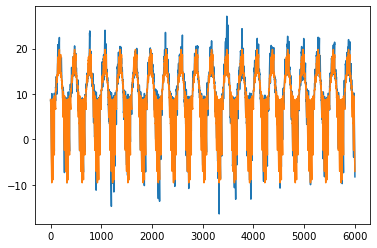

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
lonpt = 15
latpt = 10
plt.plot(t2m[-20:,:,latpt,lonpt].flatten())
plt.plot(climext[-20:,:,latpt,lonpt].flatten())

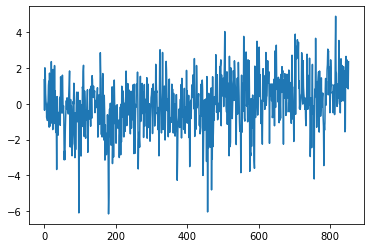

In [16]:
plt.plot(anom[:,:,latpt,lonpt].flatten())

(array([0.02125078, 0.01062539, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.01062539, 0.        , 0.01062539, 0.        , 0.        ,
        0.        , 0.        , 0.02125078, 0.        , 0.01062539,
        0.01062539, 0.01062539, 0.02125078, 0.02125078, 0.01062539,
        0.01062541, 0.02125078, 0.05312695, 0.05312695, 0.09562851,
        0.03187624, 0.03187617, 0.02125078, 0.05312695, 0.05312695,
        0.08500312, 0.07437789, 0.05312695, 0.1062539 , 0.09562851,
        0.12750482, 0.15938085, 0.14875546, 0.12750482, 0.2125078 ,
        0.17000643, 0.2125078 , 0.11687935, 0.27626014, 0.18063173,
        0.23375871, 0.3081364 , 0.22313325, 0.30813648, 0.23375866,
        0.42501578, 0.31876183, 0.36126346, 0.297511  , 0.3081364 ,
        0.31876188, 0.18063173, 0.30813631, 0.19125713, 0.20188241,
        0.30813665, 0.1062539 , 0.13813007, 0.18063183, 0.11687929,
        0.17000643, 0.14875546, 0.12750468, 0.09

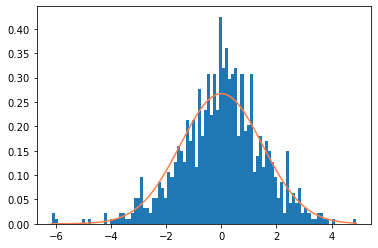

In [17]:
anomaux = anom[:,:,latpt,lonpt].flatten()
mean, std = stats.norm.fit(anomaux)
x = np.linspace(np.min(anomaux), np.max(anomaux), 2000)

y = stats.norm.pdf(x,mean,std)

plt.plot(x,y, color='coral')
plt.hist(anomaux, 100, density=True)

6) are the anomalies following a gaussian distribution


In [18]:
stats.normaltest(anomaux, axis=0)

NormaltestResult(statistic=32.371203357373616, pvalue=9.347220863480985e-08)

En general buscamos pvalue < 0.05 o 0.01 (significant a 95% o 99%)

In [19]:
stats.normaltest(anomaux, axis=0).pvalue<0.01

True

calcular la anomalias de temperatura en verano (JJA)

In [20]:
anomJJA = np.mean(anom[:,[5,6,7],:,:], axis=1)

Utilizando una regression linear calcular la tendencia de las temperaturas (https://realpython.com/linear-regression-in-python/)

In [21]:
from sklearn.linear_model import LinearRegression
# primero creamos el vector x que contiene todos los años
x = np.arange(nyear)
model = LinearRegression() # creamos una instancia de la classe linear regression
# hacer el fit (los argumentos tienen que ser 2D, añadimos una dimension extra de talla 1)
trend = np.array([LinearRegression().fit(x[:, np.newaxis], anomJJA[:,ilat,:]).coef_  for ilat in range(nlat)]).squeeze()

Nos gustaria estimar si esta regrecion es significante y adequeda, por eso podemos utilizar una otra funcion de regresion linear.

In [22]:
#creamos dos arrays para guardar la trend, el score y la pvalue
trend2 = np.zeros((nlat, nlon))
r2 = np.zeros((nlat, nlon))
pvalue = np.zeros((nlat, nlon))

for ilat in range(nlat):
    for ilon in range(nlon):
        linreg = stats.linregress(x,anomJJA[:,ilat,ilon])
        trend2[ilat, ilon] = linreg.slope
        r2[ilat, ilon] = linreg.rvalue
        pvalue[ilat, ilon] = linreg.pvalue
        

In [23]:
#comparamos el resultado de los dos calculos
normmax = np.max(trend2-trend) #norm infinita
norm2 = np.sqrt(np.sum((trend2-trend)*(trend2-trend))) #norm cuadrada
print(normmax, norm2)

3.469446951953614e-18 1.967605385971188e-16


Haremos nuestro primer mapa:

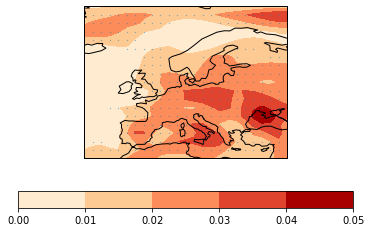

In [24]:
#import cartopy for plotting maps
import cartopy.crs as ccrs
#create a projection
data_crs = ccrs.PlateCarree()
#define a map
ax = plt.axes(projection=ccrs.PlateCarree())
#drw coastline
ax.coastlines()
#put longitude from -180 to 180
lon[lon>180]=lon[lon>180]-360
# create 2d lon lat
lon2d, lat2d = np.meshgrid(lon, lat)
#plot
cs = ax.contourf(lon2d, lat2d, trend2, np.arange(6)/100., transform=data_crs, cmap=plt.cm.OrRd)
#put dots where the p.value is significant
signi = np.where(pvalue<0.01)
ax.plot(lon2d[signi], lat2d[signi], linestyle='none', marker="o", markersize=0.2)
# drw color bar
cbar = plt.colorbar(cs, orientation="horizontal")

para encontrar color bar: http://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3

hemos hecho regreciones sobre los años, para mirar la tendencia, pero tambien podemos hacer regrecion utilizando un indice climatico para enetender la relation entre dos phenomenos.

Leemos los datos de temperatura en la region El Niño.
Para simplificar el problema, haremos aqui unas aproximaciones, primero utilizaremos la la air temperature en vez de la temperature de superficie del mar y despues haremos la media sin ponderar por el tamaño de los grid cell (es acceptable porque estamos cerca del equador en una grid regular).

In [25]:
lon_bnds = [190, 240]
lat_bnds = [-5, 5]
urlbase = "https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface/"
filename = urlbase+"air.mon.mean.nc" 
ENSO, dates, lonENSO, latENSO = readregion(filename, "air", lon_bnds, lat_bnds)

In [26]:
fullyear = np.where(dates<datetime(year=2019, month=1, day=1))[0]
nyear = int(len(fullyear)/12)

In [27]:
#hacemos la media en longitude y latitude
ENSO = np.mean(ENSO, axis=(1,2))
#quitamos los años incompletos
ENSO = ENSO[fullyear]
#reorganizamos los datos en años x meses
ENSO.shape = (nyear, 12)
#calculamos la clim y la repetimos 
climENSO = np.expand_dims(np.mean(ENSO, axis=0), axis=0).repeat(nyear, axis=0)
#anomalias
anomENSO = ENSO - climENSO
#media estaciona
anomENSOJJA = np.mean(anomENSO[:,[5,6,7]], axis=1)

In [28]:
#creamos dos arrays para guardar la trend, el score y la pvalue
regENSO = np.zeros((nlat, nlon))
r2ENSO = np.zeros((nlat, nlon))
pvalueENSO = np.zeros((nlat, nlon))

for ilat in range(nlat):
    for ilon in range(nlon):
        linreg = stats.linregress(anomENSOJJA,anomJJA[:,ilat,ilon])
        regENSO[ilat, ilon] = linreg.slope
        r2ENSO[ilat, ilon] = linreg.rvalue
        pvalueENSO[ilat, ilon] = linreg.pvalue
        

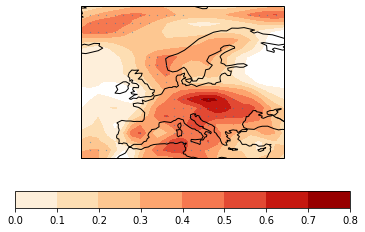

In [29]:
#import cartopy for plotting maps
import cartopy.crs as ccrs
#create a projection
data_crs = ccrs.PlateCarree()
#define a map
ax = plt.axes(projection=ccrs.PlateCarree())
#drw coastline
ax.coastlines()
#put longitude from -180 to 180
lon[lon>180]=lon[lon>180]-360
# create 2d lon lat
lon2d, lat2d = np.meshgrid(lon, lat)
#plot
cs = ax.contourf(lon2d, lat2d, regENSO, np.arange(9)/10., transform=data_crs, cmap=plt.cm.OrRd)
#put dots where the p.value is significant
signi = np.where(pvalueENSO<0.05)
ax.plot(lon2d[signi], lat2d[signi], linestyle='none', marker="o", markersize=0.2)
# drw color bar
cbar = plt.colorbar(cs, orientation="horizontal")

In [30]:
regENSO.max()

0.7281335703960753